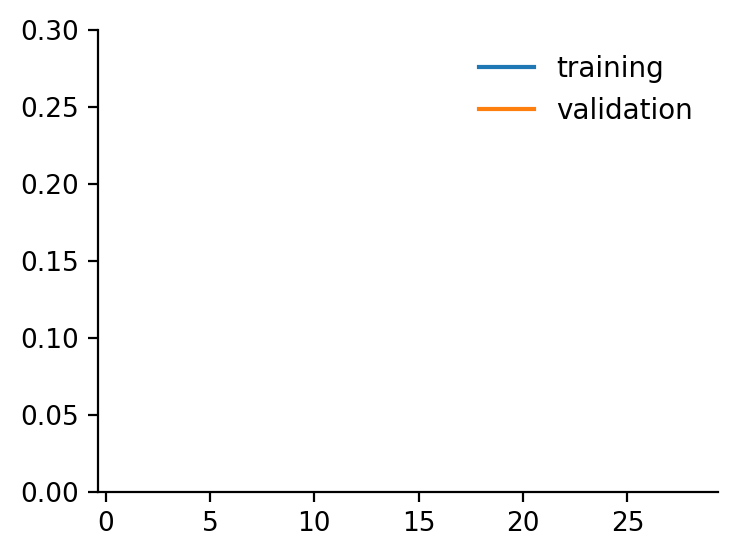

In [25]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


dir = Path("../results/fine_tuning/version-1/runs")
_df = pd.read_csv(sorted(dir.glob("**/metrics_epoch.csv"))[-1])
plt.figure(figsize=(4, 3))
plt.plot(_df.epoch, _df.training_f_rmse, label="training")
plt.plot(_df.epoch, _df.validation_f_rmse, label="validation")
plt.ylim(0, 0.3)
plt.legend();

In [26]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
from plotting_utils import style_defaults, log_log
plt.rcParams.update(style_defaults)
%config InlineBackend.figure_format = 'retina'

SP2, SP3 = "#8B7EC8", "#CE5D97"

In [27]:
from scripts.direct_training import direct_training

direct_df = direct_training.to_dataframe(
    config=dict(dataset_name="Si-GAP-18:scaled-to-C")
)
direct_df.groupby("n_train")[["test_force_rmse"]].count().T

n_train,25,50,100,200,400,800,1600
test_force_rmse,5,5,5,5,5,5,5


In [28]:
from scripts.fine_tuning import fine_tuning

finetuned_df = fine_tuning.to_dataframe(
    config=dict(
        finetune_dataset="Si-GAP-18:scaled-to-C",
    )
)

In [29]:
sp2_pretrained_df = direct_training.to_dataframe(
    config=dict(dataset_name="C-SYNTH-23M:sp2")
)
sp3_pretrained_df = direct_training.to_dataframe(
    config=dict(dataset_name="C-SYNTH-23M:sp3")
)

combined = pd.concat([sp2_pretrained_df, sp3_pretrained_df])
combined.rename(
    columns={
        "n_train": "n_pretrain",
        "dataset_name": "pretrain_dataset",
    },
    inplace=True,
)

df = finetuned_df.join(
    combined.set_index("id"),
    on="pretrain_id",
    rsuffix="_pretrain",
)

In [30]:
# sp2
df[df.pretrain_dataset == "C-SYNTH-23M:sp2"].groupby(
    ["n_pretrain", "n_finetune"]
)[["test_force_rmse"]].count().unstack()

test_force_rmse                              
n_finetune            25   50   100  200  400  800  1600
n_pretrain                                              
100                      5    5    5    5    5    5    5
330                      5    5    5    5    5    5    5
1000                     5    5    5    5    5    5    5
3300                     5    5    5    5    5    5    5
10000                    5    5    5    5    5    5    5

In [31]:
# sp3
df[df.pretrain_dataset == "C-SYNTH-23M:sp3"].groupby(
    ["n_pretrain", "n_finetune"]
)[["test_force_rmse"]].count().unstack()

test_force_rmse                              
n_finetune            25   50   100  200  400  800  1600
n_pretrain                                              
100                      5    5    5    5    5    5    5
330                      5    5    5    5    5    5    5
1000                     5    5    5    5    5    5    5
3300                     5    5    5    5    5    5    5
10000                    4    4    4    4    4    3    3

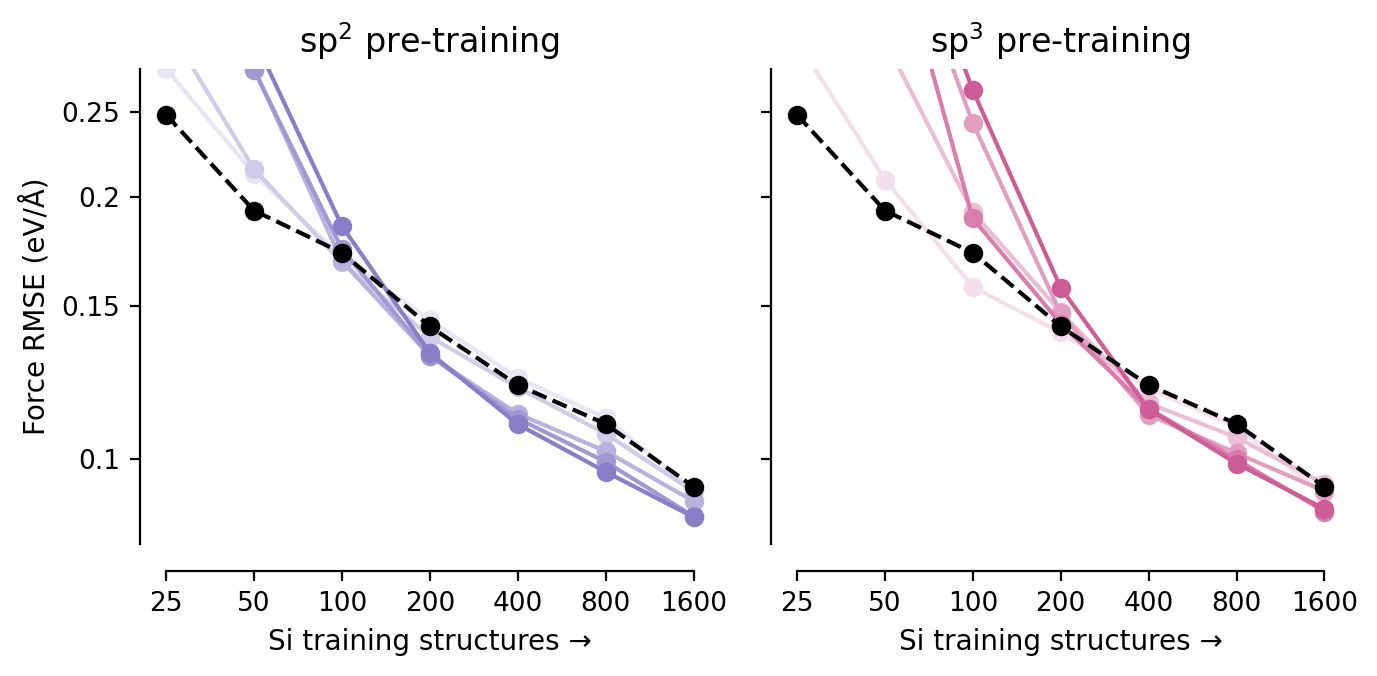

In [32]:
# SP2 / 3 seperately
from plotting_utils import colour_gradient

yticks = [0.1, 0.15, 0.2, 0.25, 0.3]
xticks = sorted(set(direct_df.n_train) | set(df.n_finetune))

fig, axs = plt.subplots(1, 2, figsize=(7, 3.5), sharey=True)

for ax, pretrain_set, base_colour in zip(axs, ("sp2", "sp3"), (SP2, SP3)):
    pretty = pretrain_set[:-1] + "$^" + pretrain_set.upper()[-1] + "$"
    ax.set_title(f"{pretty} pre-training")

    for n_pretrain, colour in colour_gradient(
        [100, 330, 1_000, 3_300, 10_000], base_colour
    ):
        idx = (df.pretrain_dataset == f"C-SYNTH-23M:{pretrain_set}") & (
        df.n_pretrain == n_pretrain
    )
        sub_df = df[idx].groupby("n_finetune").min(numeric_only=True).reset_index()
        ax.plot(
            sub_df.n_finetune,
            sub_df.test_force_rmse,
            "-o",
            color=colour,
        )
    direct_results = direct_df.groupby("n_train").min(numeric_only=True).reset_index()
    ax.plot(
        direct_results.n_train, direct_results.test_force_rmse, "--ok", label="Direct"
    )

    log_log(ax=ax, xticks=xticks, yticks=yticks)
    # ax.set_ylim(0.08, 0.35)
    ax.set_xlabel("Si training structures →")
    ax.spines["bottom"].set_position(("outward", 10))
    ax.spines["bottom"].set_bounds(xticks[0], xticks[-1])

axs[0].set_ylabel("Force RMSE (eV/Å)")
plt.ylim(0.08, 0.28)
fig.tight_layout()

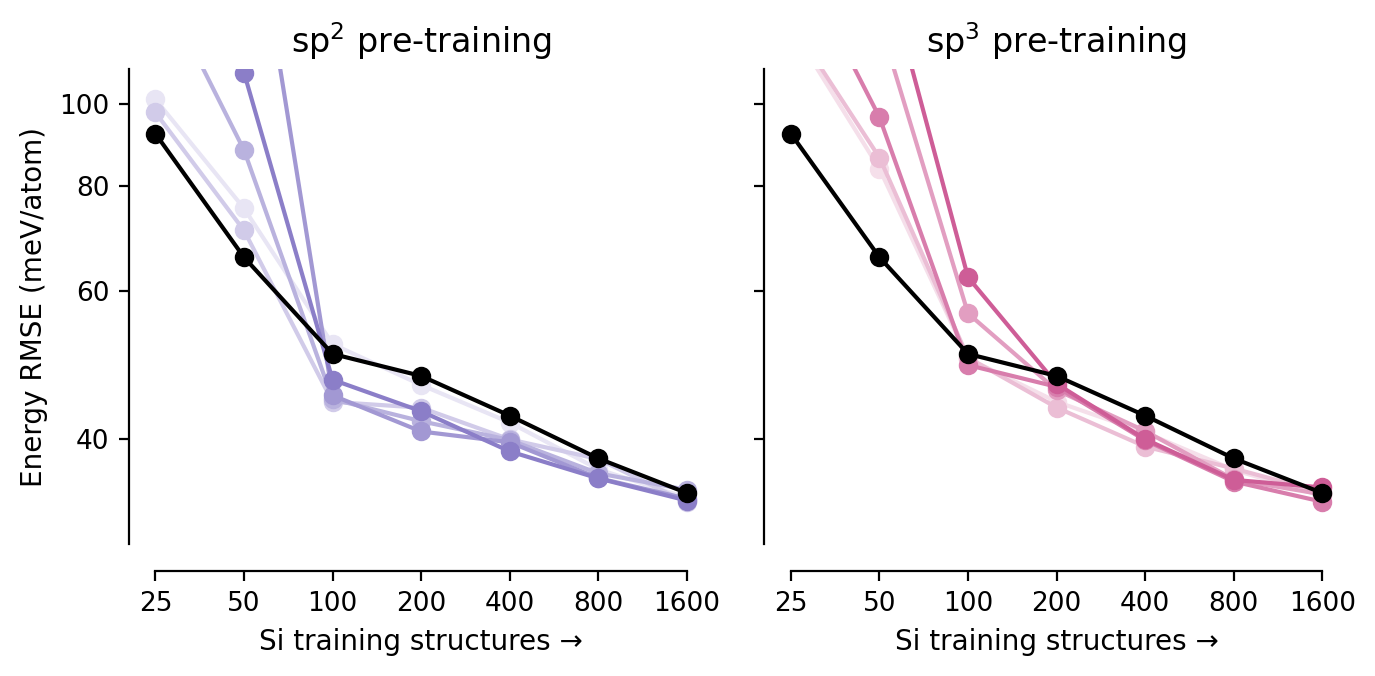

In [33]:
yticks = [40, 60, 80, 100]
xticks = sorted(set(direct_df.n_train) | set(df.n_finetune))

fig, axs = plt.subplots(1, 2, figsize=(7, 3.5), sharey=True)

for ax, pretrain_set, base_colour in zip(axs, ("sp2", "sp3"), (SP2, SP3)):
    pretty = pretrain_set[:-1] + "$^" + pretrain_set.upper()[-1] + "$"
    ax.set_title(f"{pretty} pre-training")

    for n_pretrain, colour in colour_gradient(
        [100, 330, 1_000, 3_300, 10_000], base_colour
    ):
        idx = (df.pretrain_dataset == f"C-SYNTH-23M:{pretrain_set}") & (
        df.n_pretrain == n_pretrain
    )
        sub_df = df[idx].groupby("n_finetune").min(numeric_only=True).reset_index()
        ax.plot(
            sub_df.n_finetune,
            sub_df.test_per_atom_energy_rmse * 1000,
            "-o",
            color=colour,
        )
    direct_results = direct_df.groupby("n_train").min(numeric_only=True).reset_index()
    ax.plot(
        direct_results.n_train, direct_results.test_per_atom_energy_rmse * 1000, "-ok", label="Direct"
    )

    log_log(ax=ax, xticks=xticks, yticks=yticks)
    ax.set_ylim(30, 110)
    ax.set_xlabel("Si training structures →")
    ax.spines["bottom"].set_position(("outward", 10))
    ax.spines["bottom"].set_bounds(xticks[0], xticks[-1])

axs[0].set_ylabel("Energy RMSE (meV/atom)")
fig.tight_layout()

Direct Training on Si:

In [34]:
direct = direct_df.groupby("n_train")[["test_force_rmse"]].min().round(4).rename(
    columns={"test_force_rmse": "Direct"}
).T
direct

n_train,25,50,100,200,400,800,1600
Direct,0.2483,0.1928,0.1725,0.142,0.1216,0.1098,0.093


In [38]:
sp2 = df[
    (df.pretrain_dataset == "C-SYNTH-23M:sp2") &
    (df.n_pretrain == 10_00)
].groupby(
    ["n_finetune"]
)[["test_force_rmse"]].min().round(4).rename(
    columns={"test_force_rmse": "SP2"}
).T
sp2

n_finetune,25,50,100,200,400,800,1600
SP2,0.3929,0.2804,0.1686,0.1314,0.1127,0.1021,0.0895


In [36]:
sp3 = df[
    (df.pretrain_dataset == "C-SYNTH-23M:sp3") &
    (df.n_pretrain == 10_00)
].groupby(
    ["n_finetune"]
)[["test_force_rmse"]].min().round(4).rename(
    columns={"test_force_rmse": "SP3"}
).T
sp3

n_finetune,25,50,100,200,400,800,1600
SP3,0.7444,0.457,0.2429,0.1469,0.1125,0.1016,0.0919


In [51]:
# stack them
table = pd.concat([direct.T, sp2.T, sp3.T], axis=1)
table["sp2-p"] = ((table.Direct - table.SP2) / table.Direct * 100).round(2)
table["sp3-p"] = ((table.Direct - table.SP3) / table.Direct * 100).round(2)
table.T

,25,50,100,200,400,800,1600
Direct,0.2483,0.1928,0.1725,0.1420,0.1216,0.1098,0.0930
SP2,0.3929,0.2804,0.1686,0.1314,0.1127,0.1021,0.0895
SP3,0.7444,0.4570,0.2429,0.1469,0.1125,0.1016,0.0919
sp2-p,-58.2400,-45.4400,2.2600,7.4600,7.3200,7.0100,3.7600
sp3-p,-199.8000,-137.0300,-40.8100,-3.4500,7.4800,7.4700,1.1800


In [48]:
print(table.T.style.to_latex())

\begin{tabular}{lrrrrrrr}
 & 25 & 50 & 100 & 200 & 400 & 800 & 1600 \\
Direct & 0.248300 & 0.192800 & 0.172500 & 0.142000 & 0.121600 & 0.109800 & 0.093000 \\
SP2 & 0.392900 & 0.280400 & 0.168600 & 0.131400 & 0.112700 & 0.102100 & 0.089500 \\
SP3 & 0.744400 & 0.457000 & 0.242900 & 0.146900 & 0.112500 & 0.101600 & 0.091900 \\
sp2-p & -58.240000 & -45.440000 & 2.260000 & 7.460000 & 7.320000 & 7.010000 & 3.760000 \\
sp3-p & -199.800000 & -137.030000 & -40.810000 & -3.450000 & 7.480000 & 7.470000 & 1.180000 \\
\end{tabular}

